### 1. Install and import the required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers sentence-transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8050baf134a70f9fab652020acb9fd9ea4200095bfe36576d4cb13dab71c1a6e
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer
from transformers import RobertaModel,RobertaTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer,AutoModel
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import datetime
import random
import numpy as np
import pandas as pd

### 2. Use Google Colab's GPU for training

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### **3.** Load and preview the Semantic Textual Similarity Benchmark (STSB) dataset

In [ ]:
# # Load the English version of the STSB dataset
# dataset = load_dataset("stsb_multi_mt", "en")

In [ ]:
# print(dataset)

In [ ]:
# print("A sample from the STSB dataset's training split:")
# print(dataset['train'][98])

In [ ]:
!pip install nltk

In [ ]:
test_label = '/content/drive/MyDrive/input/testdata/STS.gs.images.txt'
test_data= '/content/drive/MyDrive/input/testdata/STS.input.images.txt'
train_label = '/content/drive/MyDrive/input/traindata/STS.gs.OnWN.txt'
train_data = '/content/drive/MyDrive/input/traindata/STS.input.OnWN.txt'
train_label2 = '/content/drive/MyDrive/input/testdata/STS.gs.deft-news.txt'
train_data2 = '/content/drive/MyDrive/input/testdata/STS.input.deft-news.txt'
train_label3 = '/content/drive/MyDrive/input/testdata/STS.gs.deft-forum.txt'
train_data3 = '/content/drive/MyDrive/input/testdata/STS.input.deft-forum.txt'
train_label4 = '/content/drive/MyDrive/input/testdata/STS.gs.headlines.txt'
train_data4 = '/content/drive/MyDrive/input/testdata/STS.input.headlines.txt'
train_label5 = '/content/drive/MyDrive/input/testdata/STS.gs.SMTeuroparl.txt'
train_data5 = '/content/drive/MyDrive/input/testdata/STS.input.SMTeuroparl.txt'
train_label6 = '/content/drive/MyDrive/input/testdata/STS.gs.MSRvid.txt'
train_data6 = '/content/drive/MyDrive/input/testdata/STS.input.MSRvid.txt'
train_label7 = '/content/drive/MyDrive/input/testdata/STS.gs.MSRpar.txt'
train_data7 = '/content/drive/MyDrive/input/testdata/STS.input.MSRpar.txt'
#output_path = './output/STS.output.images.txt'
from nltk.stem import *

#ファイル入力
def file_input(input_path,mode=None):
    with open(input_path,encoding='UTF-8-sig') as f:
        s = f.read()
    s = s.strip().replace('\t','\n')
    if mode == 'data':
      s = s.replace('.','')
    sentences = s.split('\n')
    return sentences

def stem(sentences):
  ps = PorterStemmer()
  for i in range(len(sentences)):
    token = sentences[i].split(' ')
    singles = [ps.stem(plural) for plural in token]
    sentences[i] = singles
  return sentences


def sub_char(sentences:list):
    new_sentenes = []
    for sentence in sentences:
        new_sentence = []
        for word in sentence:
            w = word.replace(':','').replace(';','').replace('(','').replace(')','').replace(',','').replace('.','')
            new_sentence.append(w)
        new_sentenes.append(new_sentence)
    return new_sentenes

def list_to_seq(sentences):
  new_sentences = []
  for sentnece in sentences:
    new_sentence = ' '.join(sentnece)
    new_sentences.append(new_sentence)
  return new_sentences

def str_to_float_on_list(labels):
  new_labels = []
  for label in labels:
    new_labels.append(float(label))
  return new_labels

test_sentences = file_input(test_data,'data')
stem(test_sentences)
test_sentences = list_to_seq(test_sentences)
print(test_sentences)

test_labels = file_input(test_label)
test_labels = str_to_float_on_list(test_labels)
print(test_labels)

train_sentences = file_input(train_data,'data')
stem(train_sentences)
train_sentences = list_to_seq(train_sentences)
print(train_sentences)

train_labels = file_input(train_label)
train_labels = str_to_float_on_list(train_labels)
print(train_labels)

train_sentences2 = file_input(train_data2,'data')
stem(train_sentences2)
train_sentences2 = list_to_seq(train_sentences2)
print(train_sentences2)

train_labels2 = file_input(train_label2)
train_labels2 = str_to_float_on_list(train_labels2)
print(train_labels2)

train_sentences3 = file_input(train_data3,'data')
stem(train_sentences3)
train_sentences3 = list_to_seq(train_sentences3)
print(train_sentences3)

train_labels3 = file_input(train_label3)
train_labels3 = str_to_float_on_list(train_labels3)
print(train_labels3)

train_sentences4 = file_input(train_data4,'data')
stem(train_sentences4)
train_sentences4 = list_to_seq(train_sentences4)
print(train_sentences4)

train_labels4 = file_input(train_label4)
train_labels4 = str_to_float_on_list(train_labels4)
print(train_labels4)

train_sentences5 = file_input(train_data5,'data')
stem(train_sentences5)
train_sentences5 = list_to_seq(train_sentences5)
print(train_sentences5)

train_labels5 = file_input(train_label5)
train_labels5 = str_to_float_on_list(train_labels5)
print(train_labels5)

train_sentences6 = file_input(train_data6,'data')
stem(train_sentences6)
train_sentences6 = list_to_seq(train_sentences6)
print(train_sentences6)

train_labels6 = file_input(train_label6)
train_labels6 = str_to_float_on_list(train_labels6)
print(train_labels6)

train_sentences7 = file_input(train_data7,'data')
stem(train_sentences7)
train_sentences7 = list_to_seq(train_sentences7)
print(train_sentences7)

train_labels7 = file_input(train_label7)
train_labels7 = str_to_float_on_list(train_labels7)
print(train_labels7)

print(len(test_sentences),len(test_labels),len(train_sentences),len(train_labels))
print(len(train_sentences2),len(train_labels2),len(train_sentences3),len(train_labels3))

['a cat stand on tree branch', 'a black and white cat is high up on tree branch', 'two green and white train sit on the track', 'two green and white train on track', 'a small white cat with glow eye stand underneath a chair', 'a white cat stand on the floor', 'a larg boat in the water at the marina', 'a larg boat on the sea', 'a bu drive in a street', 'red doubl decker bu drive down street', 'the lamb is look at the camera', 'a small bird stand on a log at the water edg', 'a passeng train wait in a station', 'a passeng train sit in the station', 'a woman at a dinner tabl write on her notebook', 'woman at tabl busi with someth', 'an appl comput sit on the floor', 'a macintosh comput sit on the floor', "a close-up of a brown horse' head", "a side view of a horse' head", 'a group of peopl eat at a tabl outsid', 'group of elderli peopl sit around a tabl', 'the curiou boy look in the shed', 'two small boy in a woodi area look at a shed', 'a jockey ride a hors', 'a jockey ride a hors in a pe

In [ ]:
train_sentences = train_sentences +  train_sentences2 +  train_sentences3 + train_sentences4 +  train_sentences5 +  train_sentences6 +  train_sentences7
train_labels = train_labels + train_labels2 + train_labels3 + train_labels4 + train_labels5 + train_labels6 +  train_labels7

In [ ]:
print(len(train_sentences))
print(len(train_labels))

8968
4484


In [ ]:
from datasets import Dataset, DatasetDict
test_sentence1_list = []
test_sentence2_list = []
test_similarity_score_list = []
train_sentence1_list = []
train_sentence2_list = []
train_similarity_score_list = []

for i in range(len(test_labels)):
  test_sentence1_list.append(test_sentences[2*i])
  test_sentence2_list.append(test_sentences[2*i+1])
  test_similarity_score_list.append(test_labels[i])

for i in range(len(train_labels)):
  train_sentence1_list.append(train_sentences[2*i])
  train_sentence2_list.append(train_sentences[2*i+1])
  train_similarity_score_list.append(train_labels[i])

test_dict = {
    'sentence1': test_sentence1_list,
    'sentence2': test_sentence2_list,
    'similarity_score': test_similarity_score_list
}

train_dict = {
    'sentence1': train_sentence1_list,
    'sentence2': train_sentence2_list,
    'similarity_score': train_similarity_score_list
}
my_dataset = DatasetDict({'train': Dataset.from_dict(train_dict),
                          'test': Dataset.from_dict(test_dict)
                          })
print(my_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 4484
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 750
    })
})


In [ ]:
print("A sample from the STSB dataset's training split:")
print(my_dataset['train'][0])

A sample from the STSB dataset's training split:
{'sentence1': 'the activ of learn or be train', 'sentence2': 'the gradual process of acquir knowledg', 'similarity_score': 4.0}


### **4.** Define the dataset loader class


In [ ]:
# Instantiate the BERT tokenizer
# You can use larger variants of the model, here we're using the base model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class STSBDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        # Normalize the similarity scores in the dataset
        similarity_scores = [i['similarity_score'] for i in dataset]
        self.normalized_similarity_scores = [i/5.0 for i in similarity_scores]
        self.first_sentences = [i['sentence1'] for i in dataset]
        self.second_sentences = [i['sentence2'] for i in dataset]
        self.concatenated_sentences = [[str(x), str(y)] for x,y in zip(self.first_sentences, self.second_sentences)]

    def __len__(self):
        return len(self.concatenated_sentences)

    def get_batch_labels(self, idx):
        return torch.tensor(self.normalized_similarity_scores[idx])

    def get_batch_texts(self, idx):
        return tokenizer(self.concatenated_sentences[idx], padding='max_length', max_length=128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


def collate_fn(texts):
    input_ids = texts['input_ids']
    attention_masks = texts['attention_mask']
    features = [{'input_ids': input_id, 'attention_mask': attention_mask}
                for input_id, attention_mask in zip(input_ids, attention_masks)]
    return features

### 5. Define the model class based on BERT

In [ ]:
class BertForSTS(torch.nn.Module):

    def __init__(self):
        super(BertForSTS, self).__init__()
        self.bert = models.Transformer('bert-base-uncased', max_seq_length=128)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [ ]:
class RoBERTaForSTS(torch.nn.Module):
  def __init__(self):
    super(RoBERTaForSTS,self).__init__()
    self.roberta = RobertaModel.from_pretrained('roberta-base')
    self.pre_classfier = torch.nn.Linear(768,768)

    def forward(self,input_data)



In [ ]:
roberta = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
input = tokenizer.encode(['this is test sentence','Apple is red'])
print(input)

[0, 3, 3, 2]


TypeError: ignored

In [ ]:
# Instantiate the model and move it to GPU
model = BertForSTS()
model.to(device)


NameError: ignored

In [ ]:
model = RoBERTaForSTS()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaForSTS(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

### 6. Define the Cosine Similarity loss function

In [ ]:
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fn=torch.nn.MSELoss(), transform_fn=torch.nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fn = loss_fn
        self.transform_fn = transform_fn
        self.cos_similarity = torch.nn.CosineSimilarity(dim=1)

    def forward(self, inputs, labels):
        emb_1 = torch.stack([inp[0] for inp in inputs])
        emb_2 = torch.stack([inp[1] for inp in inputs])
        outputs = self.transform_fn(self.cos_similarity(emb_1, emb_2))
        return self.loss_fn(outputs, labels.squeeze())

### 7. Prepare the training and validation data split

In [ ]:
train_ds = STSBDataset(my_dataset['train'])
#val_ds = STSBDataset(dataset['dev'])

# Create a 90-10 train-validation split.
train_size = len(train_ds)
#val_size = len(val_ds)

print('{:>5,} training samples'.format(train_size))
#print('{:>5,} validation samples'.format(val_size))

4,484 training samples


In [ ]:
batch_size = 10

train_dataloader = DataLoader(
            train_ds,  # The training samples.
            num_workers = 4,
            batch_size = batch_size, # Use this batch size.
            shuffle=True # Select samples randomly for each batch
        )

# validation_dataloader = DataLoader(
#             val_ds,
#             num_workers = 4,
#             batch_size = batch_size # Use the same batch size
#         )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 8. Define the Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)

In [ ]:
epochs = 300

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### 9. Define a helper function for formatting the elapsed training time as `hh:mm:ss`

In [ ]:
# Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 10. Define the training function, and start the training loop

In [ ]:
import pickle

In [ ]:
#test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")
test_dataset = my_dataset['test']
print(test_dataset)
# Prepare the data
first_sent = [i['sentence1'] for i in test_dataset]
second_sent = [i['sentence2'] for i in test_dataset]
full_text = [[str(x), str(y)] for x,y in zip(first_sent, second_sent)]
print(full_text)

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 750
})
[['a cat stand on tree branch', 'a black and white cat is high up on tree branch'], ['two green and white train sit on the track', 'two green and white train on track'], ['a small white cat with glow eye stand underneath a chair', 'a white cat stand on the floor'], ['a larg boat in the water at the marina', 'a larg boat on the sea'], ['a bu drive in a street', 'red doubl decker bu drive down street'], ['the lamb is look at the camera', 'a small bird stand on a log at the water edg'], ['a passeng train wait in a station', 'a passeng train sit in the station'], ['a woman at a dinner tabl write on her notebook', 'woman at tabl busi with someth'], ['an appl comput sit on the floor', 'a macintosh comput sit on the floor'], ["a close-up of a brown horse' head", "a side view of a horse' head"], ['a group of peopl eat at a tabl outsid', 'group of elderli peopl sit around a tabl'], ['the curiou boy look

In [ ]:
ans = test_dataset['similarity_score']
ans = np.array(ans)
print(ans)

[3.6  4.4  2.6  3.2  4.   0.   4.8  3.4  3.8  3.4  2.8  2.8  3.8  1.4
 4.   3.8  2.2  0.   4.4  4.   3.8  3.   4.4  0.6  3.2  2.6  3.6  2.6
 0.6  0.   2.6  1.4  4.2  0.   0.4  4.   2.25 1.2  4.   3.2  3.8  4.
 5.   1.   0.   4.4  0.4  4.   1.2  1.6  0.   3.   3.2  1.4  3.2  3.8
 0.4  1.8  3.8  3.2  3.2  0.6  2.2  3.4  1.8  4.4  2.4  3.6  0.8  0.6
 0.   0.8  4.2  3.6  2.4  3.6  3.2  0.2  2.4  0.8  4.   4.6  3.4  0.4
 3.4  0.6  3.8  3.8  2.   2.4  3.   3.8  2.   2.6  2.2  5.   2.   4.2
 3.8  0.8  0.   2.2  3.6  3.6  0.   4.6  0.   4.4  3.4  3.   1.   3.2
 3.2  4.   3.4  4.   0.   4.   2.4  3.8  3.4  4.1  4.1  4.   2.8  0.
 3.6  2.6  4.   0.   3.8  3.75 0.   1.8  3.6  1.8  4.2  2.   1.6  1.2
 3.6  4.6  3.6  3.6  4.6  3.   0.8  3.2  4.4  0.4  1.2  3.   1.2  4.
 4.2  2.8  5.   2.8  0.   2.4  2.   1.4  4.   1.8  4.   0.   4.   2.
 4.   1.4  1.6  0.   3.4  1.   1.4  3.4  4.4  2.2  0.2  4.2  4.2  4.2
 5.   0.8  2.2  4.2  4.2  3.8  0.2  2.8  4.   3.2  1.6  4.4  0.   4.
 4.   1.4  0.6  3.2  0.2 

In [ ]:
#model.eval()

def predict_similarity(sentence_pair):
  test_input = tokenizer(sentence_pair, padding='max_length', max_length = 128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']
  output = model(test_input)
  sim = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()

  return sim

In [ ]:
from scipy.stats import pearsonr

def output_pearson(ans):
  scores = []
  for example in full_text:
    scores.append(predict_similarity(example))
  scores = np.array(scores)
  peason, _ = pearsonr(scores,ans)
  return peason
#print(output_pearson(ans))

In [ ]:
def train():
  MODEL_PATH = '/content/drive/MyDrive/output'
  seed_val = 42

  criterion = CosineSimilarityLoss()
  criterion = criterion.to(device)

  random.seed(seed_val)
  torch.manual_seed(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []
  total_t0 = time.time()
  losses = []
  peasons = []

  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()

      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for train_data, train_label in tqdm(train_dataloader):

          train_data['input_ids'] = train_data['input_ids'].to(device)
          train_data['attention_mask'] = train_data['attention_mask'].to(device)

          train_data = collate_fn(train_data)
          model.zero_grad()

          output = [model(feature) for feature in train_data]

          loss = criterion(output, train_label.to(device))
          total_train_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      losses.append(total_train_loss)
      if(epoch_i % 10 == 0):
        with open(MODEL_PATH+f'/loss{epoch_i}.pickle',mode='wb') as f:
          pickle.dump(losses,f)
      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.5f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
      if(epoch_i % 10 == 0):
        torch.save(model.state_dict(),MODEL_PATH+f'/bert-sts{epoch_i}.pt')

      model.eval()
      p = output_pearson(ans)
      print(p)
      peasons.append(p)
      if(epoch_i%10 == 0):
        with open(MODEL_PATH+f'/peason{epoch_i}.pickle',mode='wb') as f:
          pickle.dump(peasons,f)

      # # ========================================
      # #               Validation
      # # ========================================

      # print("")
      # print("Running Validation...")

      # t0 = time.time()

      # model.eval()

      # total_eval_accuracy = 0
      # total_eval_loss = 0
      # nb_eval_steps = 0

      # # Evaluate data for one epoch
      # for val_data, val_label in tqdm(validation_dataloader):

      #     val_data['input_ids'] = val_data['input_ids'].to(device)
      #     val_data['attention_mask'] = val_data['attention_mask'].to(device)

      #     val_data = collate_fn(val_data)

      #     with torch.no_grad():
      #         output = [model(feature) for feature in val_data]

      #     loss = criterion(output, val_label.to(device))
      #     total_eval_loss += loss.item()

      # # Calculate the average loss over all of the batches.
      # avg_val_loss = total_eval_loss / len(validation_dataloader)

      # # Measure how long the validation run took.
      # validation_time = format_time(time.time() - t0)

      # print("  Validation Loss: {0:.5f}".format(avg_val_loss))
      # print("  Validation took: {:}".format(validation_time))

      # # Record all statistics from this epoch.
      # training_stats.append(
      #     {
      #         'epoch': epoch_i + 1,
      #         'Training Loss': avg_train_loss,
      #         'Valid. Loss': avg_val_loss,
      #         'Training Time': training_time,
      #         'Validation Time': validation_time
      #     }
      # )

  print("")
  print("Training complete!")
  with open(MODEL_PATH+f'/loss.pickle',mode='wb') as f:
    pickle.dump(losses,f)
  torch.save(model.state_dict(),MODEL_PATH+f'/bert-sts.pt')


  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return model, training_stats

In [ ]:
# Launch the training
model, training_stats = train()


======== Epoch 1 / 300 ========
Training...


  0%|          | 0/449 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/449 [00:00<?, ?it/s]


TypeError: ignored

[30.97017585951835, 21.491186602506787, 18.508448611944914, 16.263226685579866, 14.46913010859862, 13.349728186614811, 12.47577195847407, 11.46620868705213, 10.604915065225214, 9.88315703580156, 9.216610046569258, 8.713058275170624, 8.132453736383468, 7.523974349023774, 7.038627299712971, 6.681125409901142, 6.270329353166744, 5.906247958075255, 5.550306020304561, 5.132045948877931, 4.905991280102171]
[0.5822657888448434, 0.6607998769568785, 0.7021306248250635, 0.7335899979241638, 0.7481386568665166, 0.7568255005523339, 0.7649810180367393, 0.7686478204706197, 0.7714804844075641, 0.776155366740449, 0.7792148556229188, 0.7794005517242644, 0.7804798004890221, 0.7799677985080415, 0.7819011270090622, 0.7847988463136555, 0.7834833348013165, 0.7851763377731297, 0.7861661045605322, 0.7883057962296306, 0.7865631589120772]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


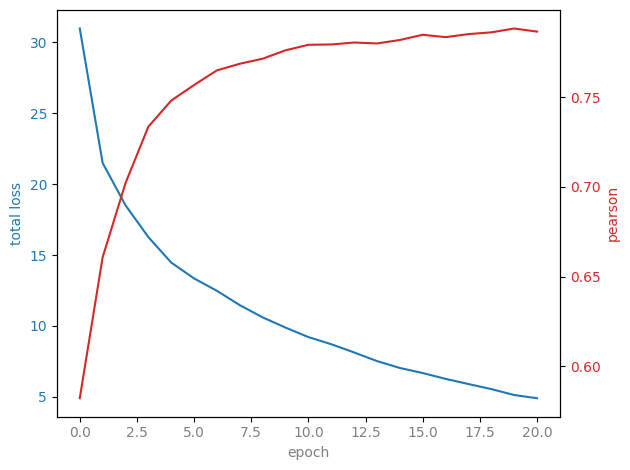

In [ ]:
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/output/loss20.pickle',mode='br') as f:
  loss = pickle.load(f)
with open('/content/drive/MyDrive/output/peason20.pickle',mode='br') as f:
  peason = pickle.load(f)
print(loss)
print(peason)

x = [i for i in range(len(peason))]
print(x)

fig,ax1 =  plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('total loss',color=color)
ax1.plot(x,loss,color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color='tab:red'
ax2.set_ylabel('pearson',color=color)
ax2.plot(x,peason,color=color)
ax2.tick_params(axis='y',labelcolor=color)

color = 'tab:gray'
ax1.set_xlabel('epoch',color=color)
ax1.tick_params(axis='x',labelcolor=color)

fig.tight_layout()
plt.savefig('/content/drive/MyDrive/output/graph2.png')
plt.show()


In [ ]:
# # Create a DataFrame from our training statistics
# df_stats = pd.DataFrame(data=training_stats)

# # Use the 'epoch' as the row index
# df_stats = df_stats.set_index('epoch')

# # Display the table
# df_stats

In [ ]:
example_1 = full_text[5]
print(f"Sentence 1: {example_1[0]}")
print(f"Sentence 2: {example_1[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_1), 2)}")

In [ ]:
example_2 = full_text[130]
print(f"Sentence 1: {example_2[0]}")
print(f"Sentence 2: {example_2[1]}")
print(f"Predicted similarity score: {round(predict_similarity(example_2), 2)}")

In [ ]:
OUTPUT_PATH  = '/content/drive/MyDrive/output/STS.output.images.txt'
output = ''
for example in full_text:
  output += str(predict_similarity(example) ) + '\n'
print(output)

In [ ]:
with open(OUTPUT_PATH,mode='w') as f:
    f.write(output)

### Last but not least, save your model!

In [ ]:
PATH = 'bert-sts.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
# In order to load the model
# First, you have to create an instance of the model's class
# And use the saving path for the loading
# Don't forget to set the model to the evaluation state using .eval()
PATH = '/content/drive/MyDrive/output/bert-sts10.pt'
model = BertForSTS()
model.load_state_dict(torch.load(PATH))
model.eval()